In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os
import mne
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, BatchNormalization, Input,UpSampling1D
from tensorflow.keras.layers import concatenate, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D,LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

c:\Users\ryoii\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ryoii\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# set directory
parent_dir = os.path.dirname(os.getcwd())

os.chdir(parent_dir)
print("Updated Working Directory:", os.getcwd())

Updated Working Directory: c:\Users\ryoii\Desktop\EEG2IMAGE


In [3]:
import mne

def print_edf_metadata(file_path):
    """
    Print metadata from an EDF file.

    Parameters:
        file_path (str): Path to the EDF file.
    """
    # Load the EDF file
    raw_data = mne.io.read_raw_edf(file_path, preload=False, verbose=False)
    
    # Print basic information
    print("File Info:")
    print(f"Sampling Frequency: {raw_data.info['sfreq']} Hz")
    print(f"Number of Channels: {len(raw_data.info['ch_names'])}")
    print(f"Channel Names: {raw_data.info['ch_names']}")
    print(f"Recording Duration: {raw_data.times[-1]} seconds")
    
    # Additional metadata from the header
    edf_header = raw_data.info
    print("\nEDF Header:")
    for key, value in edf_header.items():
        print(f"{key}: {value}")

    # Print a summary of the raw object
    print("\nRaw Data Summary:")
    print(raw_data)

print_edf_metadata("C:/Users/ryoii/Desktop/EEG2IMAGE/data/Envisioned_Speech_Recognition/Char/aashay_A.edf")

File Info:
Sampling Frequency: 128.0 Hz
Number of Channels: 39
Channel Names: ['COUNTER', 'INTERPOLATED', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'RAW_CQ', 'GYROX', 'GYROY', 'MARKER', 'SYNC', 'TIME_STAMP_s', 'TIME_STAMP_ms', 'CQ_AF3', 'CQ_F7', 'CQ_F3', 'CQ_FC5', 'CQ_T7', 'CQ_P7', 'CQ_O1', 'CQ_O2', 'CQ_P8', 'CQ_T8', 'CQ_FC6', 'CQ_F4', 'CQ_F8', 'CQ_AF4', 'CQ_CMS', 'CQ_DRL']
Recording Duration: 11.9921875 seconds

EDF Header:
acq_pars: None
acq_stim: None
ctf_head_t: None
description: None
dev_ctf_t: None
dig: None
experimenter: None
utc_offset: None
device_info: None
file_id: None
highpass: 0.0
hpi_subsystem: None
kit_system_id: None
helium_info: None
line_freq: None
lowpass: 64.0
meas_date: 2017-02-25 20:29:24+00:00
meas_id: None
proj_id: None
proj_name: None
subject_info: {'his_id': '1'}
xplotter_layout: None
gantry_angle: None
bads: []
chs: [{'cal': 1.0, 'logno': 1, 'scanno': 1, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': '

In [14]:
# Load EDF Data
def load_alphabet(folder_path, sampling_rate=128, signal_duration=10):
    """
    Load EEG data and labels from the specified folder.

    Parameters:
        folder_path (str): Path to the folder containing EEG .edf files.
        sampling_rate (int): Sampling rate of EEG data (Hz).
        signal_duration (int): Duration of EEG signals to extract (seconds).

    Returns:
        tuple: EEG data (numpy.ndarray), labels (numpy.ndarray).
    """
    label_map = {
        'A': 0, 'C': 1, 'F': 2, 'H': 3, 'J': 4,
        'M': 5, 'P': 6, 'S': 7, 'T': 8, 'Y': 9
    }
    
    X = []
    Y = []
    samples_to_extract = sampling_rate * signal_duration
    
    for fi in os.listdir(folder_path):
        if fi.endswith('.edf'):
            file_path = os.path.join(folder_path, fi)
            data = mne.io.read_raw_edf(file_path, preload=False)
            arr = data.ch_names[2:16]
            raw_data = data[2:16][0]  # Extract 14 channels
            
            # Extract label character from the filename
            label_char = fi.split('_')[1][0]
            
            # Map the character to its corresponding numeric label
            if label_char in label_map:
                label = label_map[label_char]
            else:
                raise ValueError(f"Unexpected label character '{label_char}' in file: {fi}")
            
            X.append(raw_data[:, :samples_to_extract])  # Extract required duration
            Y.append(label)
    
    return np.array(X), np.array(Y), arr

def load_digits(folder_path, sampling_rate=128, signal_duration=10):
    """
    Load digit classification data from EEG files in the specified folder.

    Parameters:
        folder_path (str): Path to the folder containing the EEG .edf files.
        sampling_rate (int): Sampling rate of EEG data (Hz).
        signal_duration (int): Duration of EEG signals to extract (seconds).

    Returns:
        tuple: A tuple containing:
            - X (numpy.ndarray): The feature matrix of shape (n_samples, 14, sampling_rate * signal_duration).
            - Y (numpy.ndarray): The labels array of shape (n_samples,).
            - channel_names (list): The list of channel names.
    """
    X = []
    Y = []
    samples_to_extract = sampling_rate * signal_duration
    channel_names = []

    for fi in os.listdir(folder_path):
        if fi.endswith('.edf'):
            file_path = os.path.join(folder_path, fi)
            data = mne.io.read_raw_edf(file_path, preload=False)
            if not channel_names:
                channel_names = data.ch_names[2:16]
            raw_data = data[2:16][0]  # Extract 14 channels
            label = int(fi.split('_')[1][0])  # Extract digit label (0-9)
            X.append(raw_data[:, :samples_to_extract])  # Extract required duration
            Y.append(label)
    return np.array(X), np.array(Y), channel_names

def load_objects(folder_path, sampling_rate=128, signal_duration=10):
    """
    Load object classification data from EEG files in the specified folder.

    Parameters:
        folder_path (str): Path to the folder containing the EEG .edf files.
        sampling_rate (int): Sampling rate of EEG data (Hz).
        signal_duration (int): Duration of EEG signals to extract (seconds).

    Returns:
        tuple: A tuple containing:
            - X (numpy.ndarray): The feature matrix of shape (n_samples, 14, sampling_rate * signal_duration).
            - Y (numpy.ndarray): The labels array of shape (n_samples,).
            - channel_names (list): The list of channel names.
    """
    X = []
    Y = []
    samples_to_extract = sampling_rate * signal_duration
    channel_names = []

    object_labels = {
        "Apple": 0, "Car": 1, "Dog": 2, "Gold": 3, "Mobile": 4,
        "Rose": 5, "Scooter": 6, "Tiger": 7, "Wallet": 8, "Watch": 9
    }

    for fi in os.listdir(folder_path):
        if fi.endswith('.edf'):
            file_path = os.path.join(folder_path, fi)
            data = mne.io.read_raw_edf(file_path, preload=False)
            if not channel_names:
                channel_names = data.ch_names[2:16]
            raw_data = data[2:16][0]  # Extract 14 channels
            cls = fi.split('_')[1].split('.')[0].strip()  # Extract class name
            label = object_labels.get(cls, -1)  # Map object name to label
            if label == -1:
                continue  # Skip if class name not found in object_labels
            X.append(raw_data[:, :samples_to_extract])  # Extract required duration
            Y.append(label)
    return np.array(X), np.array(Y), channel_names


In [5]:
def scale_to_microvolts(X):
    """
    Scale EEG data from volts to microvolts.

    Parameters:
        X (numpy.ndarray): EEG data in volts.

    Returns:
        numpy.ndarray: EEG data in microvolts.
    """
    return X * 1e6

In [6]:
def plot_eeg_signal(X, channel_index, sample_limit=200):
    """
    Plot the EEG signal for a specific channel.

    Parameters:
    X (numpy.ndarray): The feature matrix of shape (230, 14, 1280).
    channel_index (int): The index of the channel to visualize (0-13).
    sample_limit (int): The number of samples to plot on the x-axis (default is 200).
    """
    if channel_index < 0 or channel_index >= X.shape[1]:
        raise ValueError("Invalid channel index. Must be between 0 and 13.")

    # Select the first instance for visualization
    signal = X[0, channel_index, :sample_limit]

    # Plot the signal
    plt.figure(figsize=(10, 5))
    plt.plot(signal)
    plt.title(f"EEG Signal - Channel {channel_index}")
    plt.xlabel("Sample Number")
    plt.ylabel("Amplitude (\u03bcV)")
    plt.grid(True)
    plt.show()

In [7]:
# preprocess - with edge padding
def preprocess_eeg_data(X):
    """
    Preprocess the EEG data using a moving average filter.

    Parameters:
        X (numpy.ndarray): Raw EEG data of shape (n_samples, n_channels, n_points).

    Returns:
        numpy.ndarray: Preprocessed EEG data of the same shape.
    """
    def moving_average(signal, window_size=5):
        # Pad edges to ensure proper filtering at the boundaries
        padded_signal = np.pad(signal, pad_width=window_size//2, mode='edge')
        smoothed_signal = np.convolve(padded_signal, np.ones(window_size) / window_size, mode='valid')
        return smoothed_signal

    X_preprocessed = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X_preprocessed[i, j, :] = moving_average(X[i, j, :])
    return X_preprocessed

In [8]:
# segment eeg data by 0.05-second window
def segment_eeg_data(X, Y, sampling_rate=128, segment_duration=0.05):
    """
    Segment EEG data into 0.05-second chunks for fine-level classification.

    Parameters:
        X (numpy.ndarray): EEG data of shape (n_samples, n_channels, n_points).
        Y (numpy.ndarray): Labels of shape (n_samples,).
        sampling_rate (int): Sampling rate of the EEG data (Hz).
        segment_duration (float): Duration of each segment in seconds.

    Returns:
        tuple: Segmented EEG data and expanded labels.
    """
    segment_size = int(sampling_rate * segment_duration)  # Calculate segment size (6 samples)
    n_samples, n_channels, n_points = X.shape
    n_segments = n_points // segment_size

    # Initialize arrays for segmented data
    X_segmented = np.zeros((n_samples * n_segments, n_channels, segment_size))
    Y_expanded = np.repeat(Y, n_segments)

    for i in range(n_samples):
        for j in range(n_segments):
            start = j * segment_size
            end = start + segment_size
            X_segmented[i * n_segments + j, :, :] = X[i, :, start:end]

    return X_segmented, Y_expanded


In [9]:
from scipy.signal import welch
def extract_features(X_segmented):
    """
    Extract features (SD, RMS, SUM, E) from segmented EEG data.

    Parameters:
        X_segmented (numpy.ndarray): Segmented EEG data.

    Returns:
        numpy.ndarray: Feature matrix of shape (n_segments, n_channels * 4).
    """
    n_segments, n_channels, segment_size = X_segmented.shape
    feature_matrix = np.zeros((n_segments, n_channels * 5))
    for i in range(n_segments):
        for j in range(n_channels):
            segment = X_segmented[i, j, :]
            psd, _ = welch(segment, fs=128, nperseg=segment_size)

            feature_matrix[i, j * 4] = np.std(segment)  # Standard Deviation (SD)
            feature_matrix[i, j * 4 + 1] = np.sqrt(np.mean(segment ** 2))  # Root Mean Square (RMS)
            feature_matrix[i, j * 4 + 2] = np.sum(segment)  # Sum (SUM)
            feature_matrix[i, j * 4 + 3] = np.sum(segment ** 2)  # Energy (E)
            feature_matrix[i, j * 5 + 4] = np.mean(psd)  # Average PSD
    return feature_matrix


In [10]:
def train_evaluate_classifier(X, Y, fine_level_class=None):
    """
    Train and evaluate a Random Forest classifier using stratified 10-fold cross-validation
    for fine-level classification based on class type (digits, characters, or objects).
    Also visualizes feature importance.

    Parameters:
        X (numpy.ndarray): Feature matrix.
        Y (numpy.ndarray): Labels array.
        fine_level_class (str): Type of fine classification ("digits", "characters", or "objects").

    Returns:
        None
    """
    # Set number of trees based on fine-level class
    if fine_level_class == "digits":
        n_trees = 40
    elif fine_level_class == "characters":
        n_trees = 23
    elif fine_level_class == "objects":
        n_trees = 36
    else:
        raise ValueError("Invalid fine_level_class. Choose from 'digits', 'characters', or 'objects'.")

    # Initialize the classifier with class weights
    rf_clf = RandomForestClassifier(
        n_estimators=n_trees,
        criterion='gini',
        random_state=42,
        class_weight='balanced'  # Automatically handles class imbalance
    )

    # Perform stratified 10-fold cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    all_y_true = []
    all_y_pred = []

    for train_index, test_index in skf.split(X, Y):
        # Split data into training and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Train the classifier
        rf_clf.fit(X_train, Y_train)

        # Predict on the test set
        Y_pred = rf_clf.predict(X_test)

        # Store predictions and true labels
        all_y_true.extend(Y_test)
        all_y_pred.extend(Y_pred)

    # Evaluate overall performance
    print(f"Cross-Validation Accuracy ({fine_level_class}):", accuracy_score(all_y_true, all_y_pred))
    print(f"Classification Report ({fine_level_class}):\n", classification_report(all_y_true, all_y_pred))

    # Feature Importance
    feature_importances = rf_clf.feature_importances_

    # Dynamically create feature names
    feature_types = ['SD', 'RMS', 'SUM', 'E', 'psd']  # Update with all feature types you use
    n_features_per_channel = len(feature_types)
    n_channels = X.shape[1] // n_features_per_channel

    # Calculate average importance for each feature type
    avg_importance_by_type = {ft: 0 for ft in feature_types}
    for i, ft in enumerate(feature_types):
        avg_importance_by_type[ft] = np.mean(feature_importances[i::n_features_per_channel])

    # Plot average importance by feature type
    plt.figure(figsize=(8, 4))
    plt.bar(avg_importance_by_type.keys(), avg_importance_by_type.values())
    plt.xlabel("Feature Type")
    plt.ylabel("Average Importance")
    plt.title("Average Feature Importance by Type")
    plt.tight_layout()
    plt.show()

    # Print the values for reference
    for ft, importance in avg_importance_by_type.items():
        print(f"Average Importance for {ft}: {importance:.4f}")




Extracting EDF parameters from c:\Users\ryoii\Desktop\EEG2IMAGE\data\Envisioned_Speech_Recognition\Char\aashay_A.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\ryoii\Desktop\EEG2IMAGE\data\Envisioned_Speech_Recognition\Char\aashay_C.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\ryoii\Desktop\EEG2IMAGE\data\Envisioned_Speech_Recognition\Char\aashay_F.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\ryoii\Desktop\EEG2IMAGE\data\Envisioned_Speech_Recognition\Char\aashay_H.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\ryoii\Desktop\EEG2IMAGE\data\Envisioned_Speech_Recognition\Char\aashay_J.edf...
EDF file detected
Setting channel info structure...
Creating raw.inf

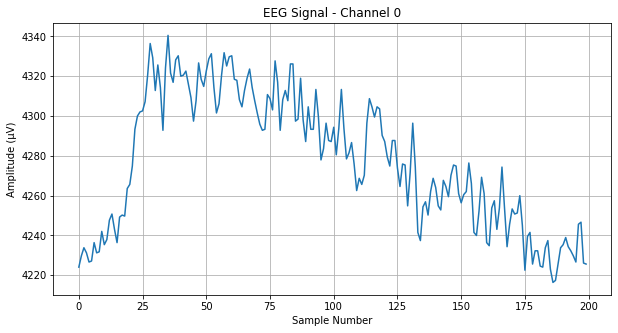

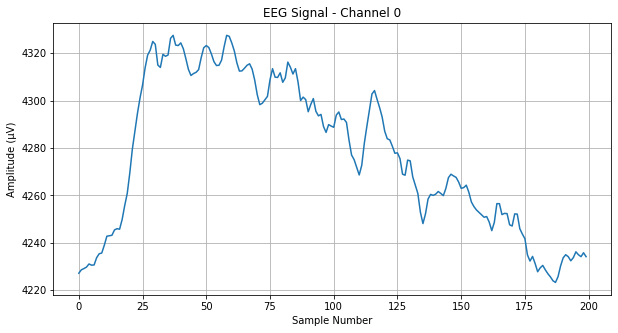

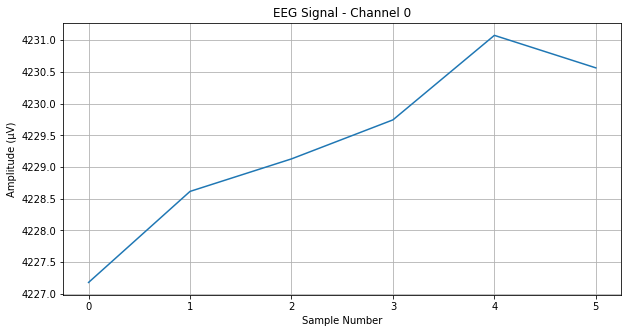

Cross-Validation Accuracy (characters): 0.6561134925494999
Classification Report (characters):
               precision    recall  f1-score   support

           0       0.61      0.69      0.65      4899
           1       0.58      0.65      0.62      4899
           2       0.64      0.67      0.66      4899
           3       0.67      0.68      0.68      4899
           4       0.64      0.65      0.64      4899
           5       0.64      0.64      0.64      4899
           6       0.79      0.74      0.76      4899
           7       0.68      0.66      0.67      4899
           8       0.67      0.61      0.64      4899
           9       0.66      0.57      0.61      4899

    accuracy                           0.66     48990
   macro avg       0.66      0.66      0.66     48990
weighted avg       0.66      0.66      0.66     48990



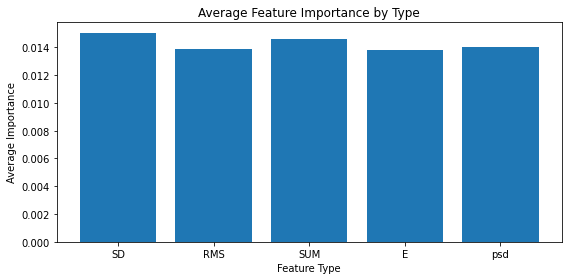

Average Importance for SD: 0.0151
Average Importance for RMS: 0.0139
Average Importance for SUM: 0.0146
Average Importance for E: 0.0138
Average Importance for psd: 0.0141


In [16]:
import pickle
# alphabet
fo = os.path.join(parent_dir, 'data', 'Envisioned_Speech_Recognition', 'Char')

X_raw, Y_raw, arr = load_alphabet(fo) # (230, 14, 1280)
X_raw = scale_to_microvolts(X_raw)
plot_eeg_signal(X_raw, sample_limit=200, channel_index=0)
X_preprocessed = preprocess_eeg_data(X_raw) # (230, 14, 1280)
plot_eeg_signal(X_preprocessed, sample_limit=200, channel_index=0)
X_segmented, Y_expanded = segment_eeg_data(X_preprocessed, Y_raw, sampling_rate=128, segment_duration=0.05) #(48990, 14, 6) (48990,)
plot_eeg_signal(X_segmented, sample_limit=50, channel_index=0)
X_features = extract_features(X_segmented) # (48990, 70)
# with open("X_features_emotiv_char.pkl", 'wb') as f:
#     pickle.dump({'X_features': X_features, 'Y_expanded': Y_expanded}, f)
train_evaluate_classifier(X_features, Y_expanded, fine_level_class='characters')

In [ ]:
# object
fo = os.path.join(parent_dir, 'data', 'Envisioned_Speech_Recognition', 'Image')

X_raw, Y_raw, arr = load_objects(fo) # (230, 14, 1280)
X_raw = scale_to_microvolts(X_raw)
plot_eeg_signal(X_raw, sample_limit=200, channel_index=0)
X_preprocessed = preprocess_eeg_data(X_raw) # (230, 14, 1280)
plot_eeg_signal(X_preprocessed, sample_limit=200, channel_index=0)
X_segmented, Y_expanded = segment_eeg_data(X_preprocessed, Y_raw, sampling_rate=128, segment_duration=0.05) #(48990, 14, 6) (48990,)
plot_eeg_signal(X_segmented, sample_limit=50, channel_index=0)
X_features = extract_features(X_segmented) # (48990, 70)
with open("X_features_emotiv_image.pkl", 'wb') as f:
    pickle.dump({'x_processed': X_preprocessed, 'y_raw': Y_raw}, f)
train_evaluate_classifier(X_features, Y_expanded, fine_level_class='objects')

In [ ]:
# load digts
fo = os.path.join(parent_dir, 'data', 'Envisioned_Speech_Recognition', 'Digit')

X_raw, Y_raw, arr = load_digits(fo) # (230, 14, 1280)
X_raw = scale_to_microvolts(X_raw)
plot_eeg_signal(X_raw, sample_limit=200, channel_index=0)
X_preprocessed = preprocess_eeg_data(X_raw) # (230, 14, 1280)
plot_eeg_signal(X_preprocessed, sample_limit=200, channel_index=0)
X_segmented, Y_expanded = segment_eeg_data(X_preprocessed, Y_raw, sampling_rate=128, segment_duration=0.05) #(48990, 14, 6) (48990,)
plot_eeg_signal(X_segmented, sample_limit=50, channel_index=0)
X_features = extract_features(X_segmented) # (48990, 70)
with open("X_features_emotiv_digit.pkl", 'wb') as f:
    pickle.dump({'x_processed': X_preprocessed, 'y_raw': Y_raw}, f)
train_evaluate_classifier(X_features, Y_expanded, fine_level_class='digits')